In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import KFold, GridSearchCV
import time
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

'''
The first cell in this script generates the final feature sets,
you just need to choose either kmeans or gmm in the cluster_definition function call below.
The output files will be called train_df_kmeans or test_df_kmeans, or gmm if you choose that.

The latter cells run the ML models (RF, SVM, XGB) along with shap importance
'''

def cluster_definition(cluster_method):
    if cluster_method == 'kmeans':
        cluster_train = 'Train 5Kmeans.csv'
        cluster_test = 'Test 5Kmeans.csv'
        cluster_mem = 'cluster_kmeans'
        cluster_method='kmeans'
    elif cluster_method == 'gmm':
        cluster_train = 'Train 2GMM.csv'
        cluster_test = 'Test 2GMM.csv'
        cluster_mem = 'cluster_ncomponents'
        cluster_method='gmm'
    return(cluster_train, cluster_test, cluster_mem, cluster_method)
cluster_train, cluster_test, cluster_mem, cluster_method = cluster_definition('gmm')

#Feature set generation
covariates = ['BMI.0.0', 'Age_recr.0.0', 'Smoking_status.0.0', 'Sex.0.0']
clusters_df_train = pd.read_csv(f"../Clustering_temp/{cluster_train}")
blood_counts = list(clusters_df_train.columns[:-4])
clusters_df_train=clusters_df_train[cluster_mem]
clusters_df_test = pd.read_csv(f"../Clustering_temp/{cluster_test}")
clusters_df_test=clusters_df_test[cluster_mem]
lifestyle=["Mood_swings.0.0","Alc_drinker_status.0.0","C_reactive_protein.0.0","Traff_int_major_rd.0.0","housing_score"]


#Train Data generation
train_data = pd.read_csv("../matching/matched_df.csv")
X_train=train_data[covariates+blood_counts+lifestyle]
y_train = train_data['cancer']
X_train=pd.merge(X_train,clusters_df_train,left_index=True, right_index=True)

#Test Data generation
test_data = pd.read_csv("../imp_test/test_imputed_df.csv")
X_test=test_data[covariates+blood_counts+lifestyle]
y_test = test_data['cancer']
X_test=pd.merge(X_test,clusters_df_test,left_index=True, right_index=True)

#Standardization
sclr=StandardScaler()
X_cols = X_train.columns
# Specify elements to remove
elements_categorical = ['Smoking_status.0.0', 'Sex.0.0','Mood_swings.0.0','Alc_drinker_status.0.0',cluster_mem]
# Create a new list that excludes the specified elements
continuous_cols = [x for x in covariates+blood_counts+lifestyle if x not in elements_categorical]
X_train[continuous_cols] = sclr.fit_transform(X_train[continuous_cols])
X_train = pd.DataFrame(X_train, columns = X_cols)
X_test[continuous_cols] = sclr.fit_transform(X_test[continuous_cols])
X_test = pd.DataFrame(X_test, columns = X_cols)
# One-hot encode the specified columns
X_train = pd.get_dummies(X_train, columns=elements_categorical)
X_test = pd.get_dummies(X_test, columns=elements_categorical)

#Feature set generation
X_train.to_csv(f'train_df_{cluster_method}.csv')
X_test.to_csv(f'test_df_{cluster_method}.csv')


One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 50}
y_pred encoded: ['healthy' 'healthy' 'healthy' ... 'leuk' 'healthy' 'leuk']
Test Set Results:
              precision    recall  f1-score   support

     healthy       0.77      0.98      0.86      2814
        leuk       0.65      0.30      0.41       459
        lymp       0.33      0.03      0.06       566

    accuracy                           0.76      3839
   macro avg       0.58      0.44      0.44      3839
weighted avg       0.69      0.76      0.69      3839



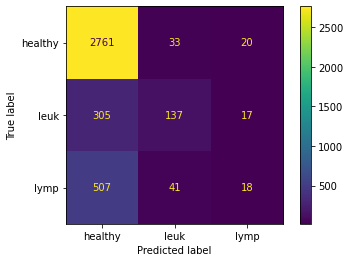

46.35549736022949 seconds or 0.7725916226704915 mins or 0.012876527044508193 hrs


In [89]:
# ML model function
xgb=XGBClassifier()
rf=RandomForestClassifier()
svm_model=svm.SVC()

def model_test_main(model,x_train,y_train,x_test,y_test):
    start_time = time.time()
    #Hyperparameter dictionaries
    if model == xgb:
        param_grid={'n_estimators'     : np.array([50, 100, 500]),
                    'learning_rate'    : np.array([1e-2, 1e-1, 1]),
                    'max_depth'        : np.array([5, 8, 10])}
        #Encoding labels for xgb compatability
        encoder = LabelEncoder()
        print(y_train)
        y_train = encoder.fit_transform(y_train)
        print(y_train)
    elif model == rf:
        param_grid={'n_estimators'   : np.array([50, 100, 200 ]),
                    'min_samples_leaf'   : np.array([1, 2, 5]),
                    'max_features' : np.array(['auto','log2'])}
    elif model == svm_model:
        param_grid={'C':[2^(0), 2^(1), 2^(2)],
                    'kernel':['poly','rbf']}
    inner=KFold(n_splits=3,shuffle=True,random_state=0)
    #Inner CV for hyperparameter tuning
    search_results=GridSearchCV(model,param_grid,cv=inner,n_jobs=-1, scoring='f1').fit(x_train,y_train)
    #Selecting optimal hyperparameters
    optimal_params=search_results.best_params_
    print(optimal_params)
    #Re-instantiating models with optimal hyperparameters
    if model==xgb:
        model=XGBClassifier(**optimal_params)
    elif model == rf:
        model =RandomForestClassifier(**optimal_params)    
    elif model==svm_model:
        model=svm.SVC(**optimal_params)
    #Fitting model with optimised parameters to training data
    model.fit(x_train,y_train)

    #Predicting using fitted model on test set
    y_pred = model.predict(x_test)
    print(f'y_pred encoded: {y_pred}')
    #De-encoding labels for xgb
    if isinstance(model,XGBClassifier):
        y_pred = encoder.inverse_transform(y_pred)
        print(f'y_pred UN-encoded: {y_pred}')
    #Results Visualisation
    print('Test Set Results:')
    print(classification_report(y_test,y_pred))
    cmatrix=ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show(cmatrix)
    time_taken=(time.time() - start_time)
    print(f'{time_taken} seconds or {time_taken/60} mins or {time_taken/(60*60)} hrs')
    return(model, y_pred)

model=model_test_main(rf, X_train, y_train, X_test, y_test)

In [9]:
# feature importance using tree impurity
features = X_train.columns
print(model[0])
importances = model[0].feature_importances_
print(importances)
indices = np.argsort(importances)
print(indices)

RandomForestClassifier(max_features='log2', min_samples_leaf=5)
[0.07704972 0.01918327 0.17625341 0.10131997 0.10120658 0.14516714
 0.15066366 0.04976887 0.07548344 0.10390393]
[1 7 8 0 4 3 9 5 6 2]


In [90]:
#Select SHAP kernel based on ML model type
if (isinstance(model[0],RandomForestClassifier))|(isinstance(model[0],XGBClassifier)):
    explainer = shap.TreeExplainer(model[0])
elif isinstance(model[0],svm.SVC):
    explainer = shap.KernelExplainer(model[0])

#Generate shap values
shap_values = explainer.shap_values(X_test)
print(model[0].classes_)

#SHAP plots for each class
plt.title('SHAP Importance Plot for Healthy Prediciton')
shap.summary_plot(shap_values, features = X_test, class_inds = [0])
plt.show()

plt.title('SHAP Density Plot for Healthy Prediction')
shap.summary_plot(shap_values[0], features = X_test)
plt.show()

plt.title('SHAP Importance Plot for Leukaemia Prediciton')
shap.summary_plot(shap_values, features = X_test, class_inds = [1])
plt.show()

plt.title('SHAP Density Plot for Leukaemia Prediction')
shap.summary_plot(shap_values[1], features = X_test)
plt.show()

plt.title('SHAP Importance Plot for Lymphoma Prediciton')
shap.summary_plot(shap_values, features = X_test, class_inds = [2])
plt.show()

plt.title('SHAP Density Plot for Lymphoma Prediction')
shap.summary_plot(shap_values[2], features = X_test)
plt.show()


In [85]:
'''
plt.title('SHAP Force Plot for Healthy Prediction')
shap.force_plot(base_value=explainer.expected_value[0], shap_values=shap_values[0])
plt.show()
'''
X_train

array([[-1.26119132, -1.08443325, -0.30279575, ..., -0.24352883,
         4.29097692, -1.28364906],
       [-0.2050863 , -1.08443325, -0.23245659, ...,  0.17328222,
        -0.74402838, -1.13668433],
       [ 1.30363517, -1.08443325, -0.30540091, ..., -0.52140286,
        -0.47549476, -0.55521517],
       ...,
       [-2.1664242 ,  0.92214067, -0.01883393, ..., -0.52140286,
        -0.47549476,  1.17002299],
       [ 0.24753014,  0.92214067,  4.46203158, ...,  0.8679673 ,
         1.53850736, -0.23572662],
       [ 0.39840229,  0.92214067,  0.04629493, ..., -0.24352883,
         1.13570693, -0.32518342]])